# 9. Beta diversity

In [1]:
# Load diversity libraries
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan) 
library(phyloseq) 
library(dplyr) 
library(ggpubr) 
library(Hmisc) 
library(corrplot)
library(scales)
library(broom)
library(ecodist) 
library(rstatix)
library(multcompView)
library(patchwork)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:

In [2]:
# Load rarefied data and filtered metadata
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data")

rarefied_data <- read.delim("./rarefied_data.tsv")
metadata_filtered <- read.delim("./metadata_filtered_Diversity.tsv")

head(rarefied_data)
head(metadata_filtered)

,X.Enterobacter.,X.Eubacterium..sulci.group,X.Eubacterium..yurii.group,X.Ruminococcus..gnavus.group,Abiotrophia,Acetoanaerobium,Achromobacter,Acidaminococcus,Acidibacter,Acidiferrimicrobium,⋯,Veillonella,Vibrio,Virgibacillus,W5053,Williamsia,Xanthobacter,Xenorhabdus,Xylophilus,Yersinia,Yokenella
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0001967K_T1,0,0,0,0,0,0,0,0,0,0,⋯,9,0,0,0,0,0,0,0,0,0
0001967K_T3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T0,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Timepoint,Sex,Age,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,T1,1,58.7,1,1,0,38,100,10,15
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,T3,1,58.7,1,1,0,38,100,10,15
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,T6,1,58.7,1,1,0,38,100,10,15
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,T0,2,60.3,1,1,0,667,800,58,22
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,T1,2,60.3,1,1,0,667,800,58,22
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,T3,2,60.3,1,1,0,667,800,58,22


In [3]:
# Creating the relative abundance df
## Convert row names to a new column (Sample_ID)
rarefied_data2 <- rarefied_data %>% 
  tibble::rownames_to_column(var = "Sample_ID")

## Compute total reads per sample
total_reads <- rowSums(rarefied_data2[ , -1]) # except for the first column, with the sample codes

## Calculate relative abundance
relative_abundance <- rarefied_data2
relative_abundance[ , -1] <- sweep(rarefied_data2[ , -1], 1, total_reads, FUN = "/") * 100

## Reshape the data to have genus names as the first column
relative_abundance <- relative_abundance %>% 
  pivot_longer(-Sample_ID, names_to = "Taxa", values_to = "Relative_Abundance") %>% 
  pivot_wider(names_from = "Sample_ID", values_from = "Relative_Abundance")

head(relative_abundance)
write.table(relative_abundance, file = "relative_abundance.tsv", sep = "\t", row.names = FALSE)

Taxa,0001967K_T1,0001967K_T3,0001967K_T6,0088303G_T0,0088303G_T1,0088303G_T3,0110059G_T0,0110059G_T12,0110059G_T3,⋯,1628845C_T1,1628845C_T3,1628845C_T6,1645117H_T0,1645117H_T1,1654702B_T0,1654702B_T1,1654702B_T6,1668337K_T0,1668337K_T1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X.Enterobacter.,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Eubacterium..sulci.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Eubacterium..yurii.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X.Ruminococcus..gnavus.group,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Abiotrophia,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Acetoanaerobium,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
## Calculates Bray-Curtis distances between samples
bray_curtis_dist <- vegan::vegdist(t(relative_abundance[, -1]), method = "bray")
bray_curtis_pcoa <- ecodist::pco(bray_curtis_dist) # Performs Principal Coordinate Analysis (PCoA) on the Bray-Curtis dissimilarity matrix to obtain principal coordinate axes
head(bray_curtis_dist)
head(bray_curtis_pcoa)

[1] 0.018 0.018 0.128 0.018 0.123 0.958

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0001967K_T1,-0.22426606,0.040730074,-0.056779926,0.03697908,0.023740540,-0.029376872,-0.008851541,-0.005030971,0.0066989444,0.005570437,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T3,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0001967K_T6,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T0,-0.20898406,0.002611263,0.022388902,-0.02017153,-0.012995254,-0.066395732,-0.045983672,-0.001529288,-0.0059635848,-0.024844720,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T1,-0.22850257,0.038406145,-0.058808235,0.04538157,0.025891595,-0.035207075,-0.006119599,-0.005192758,0.0088108479,0.007544306,⋯,0,0,0,0,0,0,0,0,0,0
0088303G_T3,-0.21856518,0.026392487,-0.039181736,0.01980840,0.009287327,0.003069837,0.006483655,-0.001223188,0.0063489825,0.002360290,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T0,0.53124170,-0.423489460,-0.211753933,-0.24829113,-0.028679339,0.190304341,0.027823402,0.068462541,0.0261729446,-0.080045977,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T12,-0.17314164,-0.021769997,0.035347746,-0.08097812,-0.054658888,0.148292856,0.055793300,0.030727532,0.0241157137,-0.024609894,⋯,0,0,0,0,0,0,0,0,0,0
0110059G_T3,0.22122676,-0.329056268,0.009212395,-0.28567301,-0.086169700,0.092140368,-0.030773006,-0.023530175,-0.0156227372,0.028085385,⋯,0,0,0,0,0,0,0,0,0,0


In [5]:
### Creates a df to store the PCoA results and assigns the first three principal coordinate axes to columns in the data frame
bray_curtis_pcoa_df <- data.frame(pcoa1 = bray_curtis_pcoa$vectors[,1], 
                                  pcoa2 = bray_curtis_pcoa$vectors[,2],
                                  pcoa3 = bray_curtis_pcoa$vectors[,3]) 
bray_curtis_pcoa_df$ID_Sample <- colnames(relative_abundance)[-1] # Assigns sample IDs as a new column in the data frame
dist_metadata <- merge(metadata_filtered, bray_curtis_pcoa_df, by = "ID_Sample") # Merges the metadata with the PCoA results based on sample IDs.
head(bray_curtis_pcoa_df)
head(dist_metadata)

,pcoa1,pcoa2,pcoa3,ID_Sample
,<dbl>,<dbl>,<dbl>,<chr>
1,-0.2242661,0.040730074,-0.05677993,0001967K_T1
2,-0.2285026,0.038406145,-0.05880824,0001967K_T3
3,-0.2285026,0.038406145,-0.05880824,0001967K_T6
4,-0.2089841,0.002611263,0.02238890,0088303G_T0
5,-0.2285026,0.038406145,-0.05880824,0088303G_T1
6,-0.2185652,0.026392487,-0.03918174,0088303G_T3


,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Atopic_Symptoms,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay,pcoa1,pcoa2,pcoa3
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,1,1,0,38,100,10,15,-0.2242661,0.040730074,-0.05677993
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,1,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,1,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,1,1,0,667,800,58,22,-0.2089841,0.002611263,0.02238890
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,1,1,0,667,800,58,22,-0.2285026,0.038406145,-0.05880824
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,1,1,0,667,800,58,22,-0.2185652,0.026392487,-0.03918174


In [7]:
print(head(dist_metadata))

    ID_Sample SNOT22 SNOT22nasal LK_Total LK_Secret ClinicCtrl AntUse Cortuse
1 0001967K_T1     38          12        4         2         NC      1       1
2 0001967K_T3     96          26       10         4         NC      1       0
3 0001967K_T6     79          19        6         4         NC      1       1
4 0088303G_T0    102          37        8         2         NC     NA       0
5 0088303G_T1     32           7        4         1         NC      1       0
6 0088303G_T3     NA          NA       NA        NA       <NA>      0       0
   Patient          Filename nreads Timepoint Sex  Age Atopic_Symptoms Asthma
1 0001967K 0001967K_T1.fastq   1061        T1   1 58.7               1      1
2 0001967K 0001967K_T3.fastq  20860        T3   1 58.7               1      1
3 0001967K 0001967K_T6.fastq  48290        T6   1 58.7               1      1
4 0088303G 0088303G_T0.fastq   9051        T0   2 60.3               1      1
5 0088303G 0088303G_T1.fastq  11707        T1   2 60.3          

In [7]:
write.table(bray_curtis_pcoa_df, file = "PCoA_values_samples.tsv", sep = "\t", row.names = FALSE)

In [9]:
# Plot
## Setting up the parameters for plotting and its colors and groups 
options(repr.plot.width=5, repr.plot.height=4)
dist_metadata_filt <- dist_metadata[dist_metadata$nreads >= 1000, ] # Filter out samples with <1000 reads

clustid_time <- dist_metadata_filt$Timepoint 
clustid_patient <- dist_metadata_filt$Patient # group samples 

my_palette4timepoint <- brewer.pal(n = 5, name = "Set1")  # Adjust 'n' based on the number of groups
num_patients <- length(unique(dist_metadata_filt$Patient))
my_palette4patients <- rainbow(num_patients)  

group_time <- c("T0", "T1", "T3", "T6", "T12")
group_patient <- unique(dist_metadata_filt$Patient)

dist_metadata_filt$Timepoint <- factor(dist_metadata_filt$Timepoint, levels = group_time, ordered = TRUE) # order the groups 
dist_metadata_filt$Patient <- factor(dist_metadata_filt$Patient, levels = group_patient, ordered = TRUE)

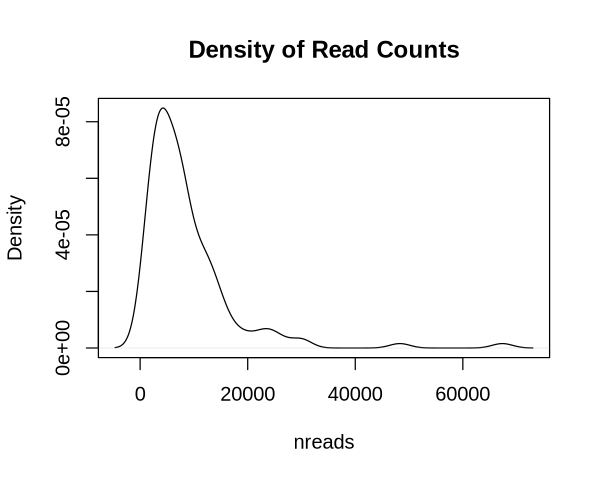

In [13]:
plot(density(dist_metadata_filt$nreads), main = "Density of Read Counts", xlab = "nreads")

In [16]:
# Check outliers using IQR 
Q1 <- quantile(dist_metadata_filt$nreads, 0.25)
Q3 <- quantile(dist_metadata_filt$nreads, 0.75)
IQR <- Q3 - Q1

lower_bound <- Q1 - 1.5 * IQR
upper_bound <- Q3 + 1.5 * IQR

## Flagging outliers
dist_metadata_filt$outlier <- dist_metadata_filt$nreads < lower_bound | dist_metadata_filt$nreads > upper_bound

## View them
dist_metadata_filt[dist_metadata_filt$outlier, ]

# Count rows before filtering
n_before <- nrow(dist_metadata_filt)

# Remove outliers (checked with IQR) and remove rows with NA
dist_metadata_no_outliers <- na.omit(dist_metadata_filt[!dist_metadata_filt$outlier, ]) 

# Count rows after filtering
n_after <- nrow(dist_metadata_no_outliers)

# Print summary
cat("Rows before filtering:", n_before, "\n")
cat("Rows after filtering (no outliers, no NAs):", n_after, "\n")
cat("Rows removed:", n_before - n_after, "\n")

,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay,pcoa1,pcoa2,pcoa3,outlier
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<ord>,<chr>,⋯,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,1,0,38.0,100,10,15,-0.2285026,0.03840614,-0.05880824,TRUE
53,0784533E_T0,102,37,8,2,NC,NA,0,0784533E,0784533E_T0.fastq,⋯,1,1,237.0,500,160,20,0.6334191,0.52482914,-0.06993160,TRUE
65,0980601G_T3,52,16,7,4,PC,0,0,0980601G,0980601G_T3.fastq,⋯,1,1,56.0,200,60,23,-0.2275021,0.03673061,-0.05651249,TRUE
93,1526680J_T12,14,11,9,3,NC,0,0,1526680J,1526680J_T12.fastq,⋯,1,1,73.0,800,65,24,0.3336891,-0.03211339,0.05072014,TRUE
98,1532317F_T3,2,2,6,4,PC,0,0,1532317F,1532317F_T3.fastq,⋯,0,0,54.1,300,45,24,0.4706245,-0.06390500,0.06100830,TRUE
109,1557602I_T1,16,8,8,4,NC,1,0,1557602I,1557602I_T1.fastq,⋯,1,0,120.0,400,80,24,-0.2285026,0.03840614,-0.05880824,TRUE
115,1560534I_T3,17,3,2,0,PC,1,0,1560534I,1560534I_T3.fastq,⋯,0,1,123.0,600,100,22,-0.2285026,0.03840614,-0.05880824,TRUE
138,1618827B_T0,23,17,10,4,NC,NA,0,1618827B,1618827B_T0.fastq,⋯,1,0,171.0,1130,120,13,-0.2282632,0.03831468,-0.05854037,TRUE
144,1645117H_T0,13,10,8,2,NC,NA,0,1645117H,1645117H_T0.fastq,⋯,0,0,NA,400,40,23,0.5624705,-0.35788675,0.09842272,TRUE


Rows before filtering: 135 
Rows after filtering (no outliers, no NAs): 85 
Rows removed: 50 


In [19]:
# write.table(dist_metadata, file = "dist_metadata080425.tsv", sep = "\t", row.names = FALSE)

png 
  3

pdf 
  2

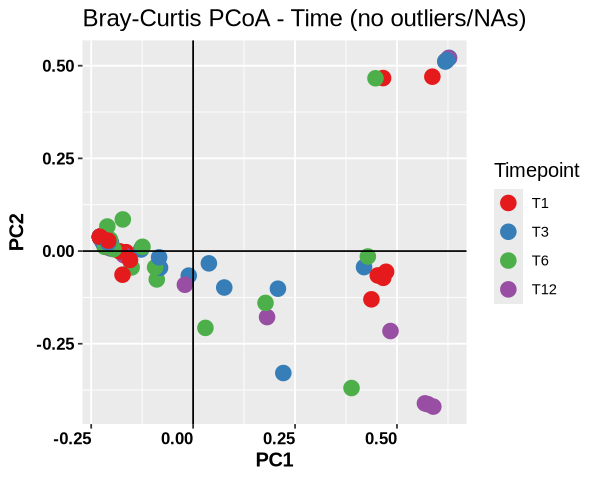

In [18]:
bray_curtis_time <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Timepoint)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4timepoint) +  # Uses the ordered factor colors
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Time (no outliers/NAs)") +
  theme(title = element_text(size = 12), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_time

# Save the plot as a PNG file
dev.copy(png, filename = "bray_curtis_time_noout.png", width = 1800, height = 1200, res = 300)
dev.off()  # Close the PNG device

png 
  3

pdf 
  2

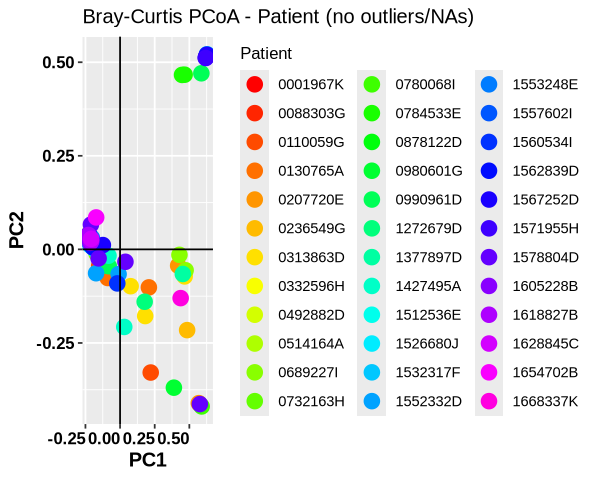

In [20]:
bray_curtis_patient <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Patient)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4patients) +  # Uses the ordered factor colors
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Patient (no outliers/NAs)") +
  guides(color = guide_legend(ncol = 3)) +  # <- This sets the legend to 3 columns
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_patient

# Save the plot as a PNG file
dev.copy(png, filename = "bray_curtis_patient_noout.png", width = 2000, height = 1200, res = 300)
dev.off()  # Close the PNG device

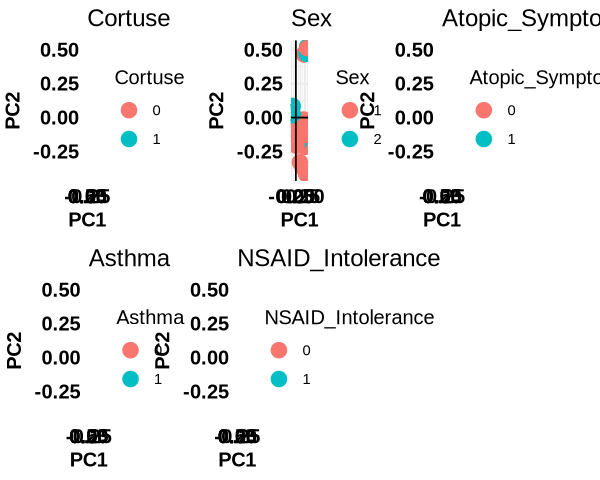

In [24]:
# Ploting PCoA using different metadata groups (boolean variables)
## List of categorical variables to use for coloring
color_vars <- c("Cortuse", "Sex", "Atopic_Symptoms", "Asthma", "NSAID_Intolerance")

## Generate multiple plots
plot_list <- lapply(color_vars, function(var) {
    ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = factor(!!sym(var)))) +
        geom_point(size = 4) +   
        #stat_ellipse(level = 0.8) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0) +
        labs(x = "PC1",
             y = "PC2", 
             color = var,  # Label for the legend
             title = paste(var)) +
        theme_minimal() +
        theme(
            title = element_text(size = 12),
            axis.text = element_text(size = 12, colour = "black", face = "bold"),
            axis.title = element_text(size = 12, colour = "black", face = "bold"),
            legend.position = "right"
        )
})

## Display the plots
p_all <- grid.arrange(grobs = plot_list, ncol = 3)

# Save the plot as a PNG file
ggsave("PCoA_boolean_vars_noout.png", p_all, width = 14, height = 10, dpi = 300)

png 
  3

pdf 
  2

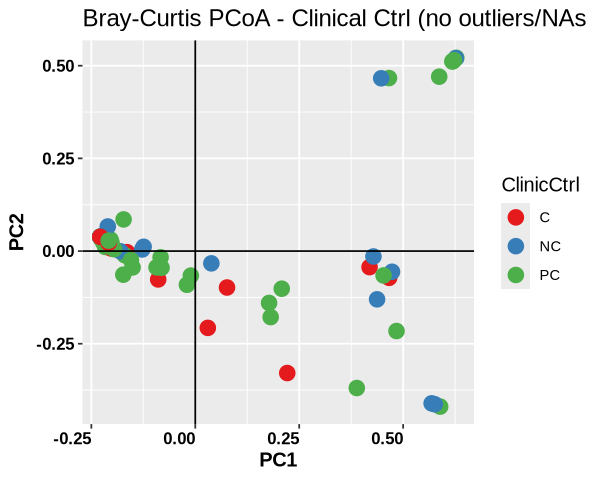

In [25]:
bray_curtis_ClinicCtrl <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = ClinicCtrl)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = my_palette4timepoint) +  # Uses the ordered factor colors
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Clinical Ctrl (no outliers/NAs") +
  theme(title = element_text(size = 12), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_ClinicCtrl

# Save the plot as a PNG file
dev.copy(png, filename = "bray_curtis_ClinicCtrl_noout.png", width = 1800, height = 1200, res = 300)
dev.off()  # Close the PNG device

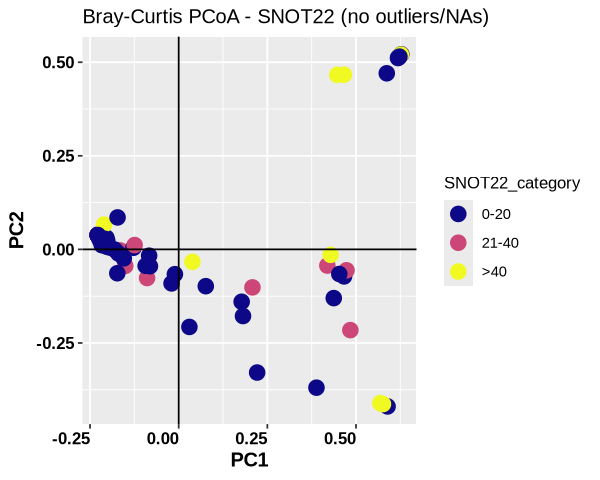

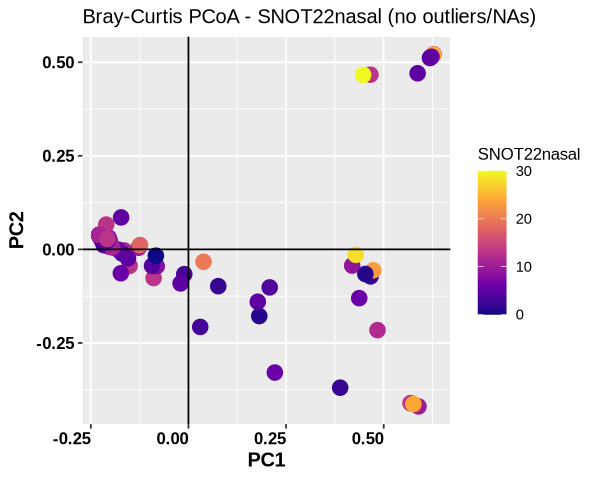

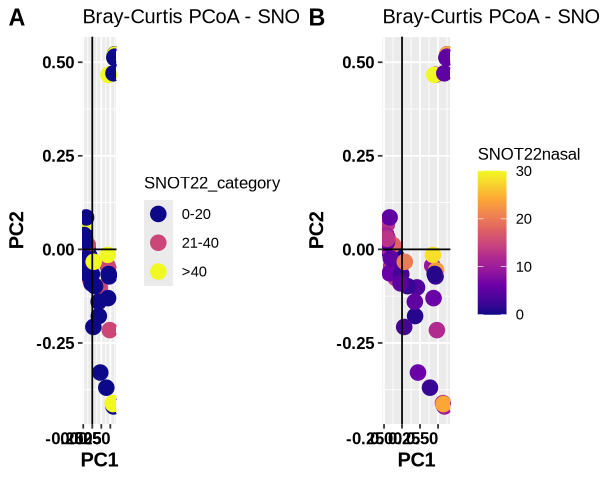

In [28]:
# Ploting PCoA using different metadata groups (numeric variables)

## SNOT22 (general x nasal)
# Define categories
dist_metadata_no_outliers$SNOT22_category <- cut(dist_metadata_no_outliers$SNOT22, 
                                          breaks = c(-Inf, 20, 40, Inf), 
                                          labels = c("0-20", "21-40", ">40"))

# Custom color palette 
snot22_palette <- c("0-20" = "#0D0887", "21-40" = "#CC4778", ">40" = "#F0F921")

# Plot for SNOT22 (Categorical)
bray_curtis_snot22 <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = SNOT22_category)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_manual(values = snot22_palette) +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - SNOT22 (no outliers/NAs)") +
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_snot22

# # Save SNOT22 plot
# ggsave("bray_curtis_snot22.png", bray_curtis_snot22, width = 6, height = 4, dpi = 300)

# Plot for SNOT22nasal (Continuous)
bray_curtis_snot22nasal <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = SNOT22nasal)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - SNOT22nasal (no outliers/NAs)") +
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))

# # Save SNOT22nasal plot
# ggsave("bray_curtis_snot22nasal.png", bray_curtis_snot22nasal, width = 6, height = 4, dpi = 300)
bray_curtis_snot22nasal

combined_SNOTplot <- ggarrange(bray_curtis_snot22, bray_curtis_snot22nasal, 
                           labels = c("A", "B"),  # Add labels to subplots
                           ncol = 2, nrow = 1,  # Arrange plots in one row
                           common.legend = FALSE)  # Keep separate legends
combined_SNOTplot

ggsave("combined_SNOTplot_noout.png", combined_SNOTplot, width = 10, height = 8, dpi = 300)


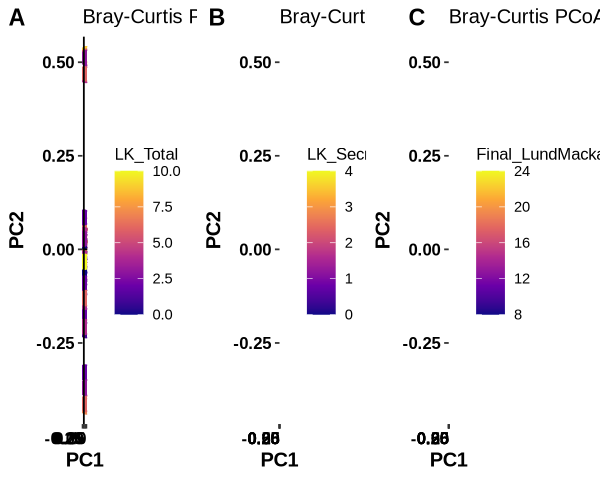

In [31]:
# Plot for LK_Total (Continuous)
bray_curtis_LKtotal <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = LK_Total)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - LK Total (no outliers/NAs)") +
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))

# Plot for LK_Secret (Continuous)
bray_curtis_LKsecret <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = LK_Secret)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - LK Secretion (no outliers/NAs)") +
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))

bray_curtis_LKfinal <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Final_LundMackay)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - LK Final (no outliers/NAs)") +
  theme(title = element_text(size = 10), 
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))

# Combine the plots into one figure
combined_LKplot <- ggarrange(bray_curtis_LKtotal, bray_curtis_LKsecret, bray_curtis_LKfinal, 
                             labels = c("A", "B", "C"),  # Add labels to subplots
                             ncol = 3, nrow = 1,  # Arrange plots in one row
                             common.legend = FALSE)  # Keep separate legends
combined_LKplot

ggsave("combined_LKplot_noout.png", combined_LKplot, width = 12, height = 8, dpi = 300)

In [19]:
head(dist_metadata_filt)

,ID_Sample,SNOT22,SNOT22nasal,LK_Total,LK_Secret,ClinicCtrl,AntUse,Cortuse,Patient,Filename,⋯,Asthma,NSAID_Intolerance,Total_IgE,Blood_Eosinophilia,Tissue_Eosinophilia,Final_LundMackay,pcoa1,pcoa2,pcoa3,SNOT22_category
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<ord>,<chr>,⋯,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,0001967K_T1,38,12,4,2,NC,1,1,0001967K,0001967K_T1.fastq,⋯,1,0,38,100,10,15,-0.2242661,0.040730074,-0.05677993,21-40
2,0001967K_T3,96,26,10,4,NC,1,0,0001967K,0001967K_T3.fastq,⋯,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824,>40
3,0001967K_T6,79,19,6,4,NC,1,1,0001967K,0001967K_T6.fastq,⋯,1,0,38,100,10,15,-0.2285026,0.038406145,-0.05880824,>40
4,0088303G_T0,102,37,8,2,NC,NA,0,0088303G,0088303G_T0.fastq,⋯,1,0,667,800,58,22,-0.2089841,0.002611263,0.02238890,>40
5,0088303G_T1,32,7,4,1,NC,1,0,0088303G,0088303G_T1.fastq,⋯,1,0,667,800,58,22,-0.2285026,0.038406145,-0.05880824,21-40
6,0088303G_T3,NA,NA,NA,NA,NA,0,0,0088303G,0088303G_T3.fastq,⋯,1,0,667,800,58,22,-0.2185652,0.026392487,-0.03918174,NA


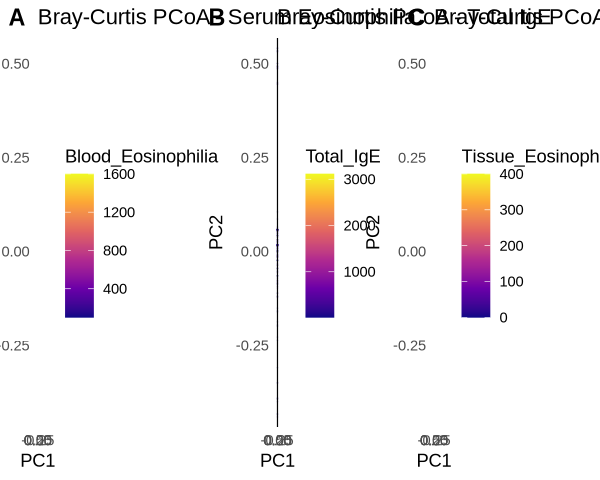

In [33]:
# Plot for Eosinofilia sérica (continuous)
bray_curtis_eosinofilia <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Blood_Eosinophilia)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Serum Eosinophilia") +
  theme_minimal()

# Plot for IgE total (continuous)
bray_curtis_ige <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Total_IgE)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Total IgE") +
  theme_minimal()

# Plot for Eosinófilos Teciduais (continuous)
bray_curtis_eos_teciduais <- ggplot(data = dist_metadata_no_outliers, aes(x = pcoa1, y = pcoa2, color = Tissue_Eosinophilia)) +
  geom_point(size = 4) +   
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  scale_color_viridis_c(option = "plasma") +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA - Tissue Eosinophilia") +
  theme_minimal()

# Combine the three plots into one figure
combined_extra_plot <- ggarrange(bray_curtis_eosinofilia, bray_curtis_ige, bray_curtis_eos_teciduais, 
                                 labels = c("A", "B", "C"), 
                                 ncol = 3, nrow = 1,  
                                 common.legend = FALSE)  
combined_extra_plot

ggsave("combined_extra_plot_noout.png", combined_extra_plot, width = 12, height = 8, dpi = 300)

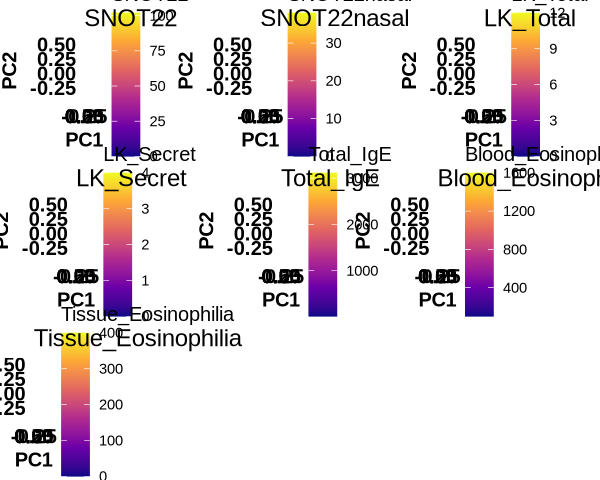

In [21]:
# Ploting PCoA using different metadata groups (numeric variables)
## List of numeric variables to use for coloring
numeric_vars <- c("SNOT22", "SNOT22nasal", "LK_Total", "LK_Secret", 
                  "Total_IgE", "Blood_Eosinophilia", "Tissue_Eosinophilia")

## Generate multiple PCoA plots with numeric color scales
plot_list <- lapply(numeric_vars, function(var) {
    ggplot(data = dist_metadata_filt, aes(x = pcoa1, y = pcoa2, color = !!sym(var))) +
        geom_point(size = 4) +   
        #stat_ellipse(level = 0.8) +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_vline(xintercept = 0, linetype = "dashed") +
        scale_color_viridis_c(option = "plasma") +  # Use a continuous color scale (viridis)
        labs(x = "PC1",
             y = "PC2", 
             color = var,  # Legend label
             title = paste(var)) +
        theme_minimal() +
        theme(
            title = element_text(size = 12),
            axis.text = element_text(size = 12, colour = "black", face = "bold"),
            axis.title = element_text(size = 12, colour = "black", face = "bold"),
            legend.position = "right"
        )
})

## Display the plots
grid.arrange(grobs = plot_list, ncol = 3)